In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from src.datasets import build_dataset
from train_sae.sae import BatchTopKSAE


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
diode_config_path = "src/datasets/diode/diode.yaml"
diode_dataset = build_dataset("diode", diode_config_path, split="val", batch_size=1)
print(f"Loaded DIODE dataset with {len(diode_dataset)} samples")

Loaded DIODE dataset with 771 samples


In [4]:
model_name = "LiheYoung/depth-anything-small-hf"
image_processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModelForDepthEstimation.from_pretrained(model_name)
model.to(device)
model.eval()

DepthAnythingForDepthEstimation(
  (backbone): Dinov2Backbone(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplac

In [5]:
def extract_embeddings(model, image):
    """Extract global embedding from Depth Anything model"""
    if isinstance(image, torch.Tensor):
        if image.ndim == 3 and image.shape[0] == 3:
            image_np = image.permute(1, 2, 0).cpu().numpy()
            if image_np.max() <= 1.0:
                image_np = (image_np * 255).astype(np.uint8)
            image = Image.fromarray(image_np)
    
    # Process image for the model
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    
    # Extract embeddings directly using the backbone components
    with torch.no_grad():
        patches = model.backbone.embeddings.patch_embeddings(inputs.pixel_values)
        encoder_outputs = model.backbone.encoder(patches)
        hidden_states = model.backbone.layernorm(encoder_outputs[0])
        
        global_embedding = hidden_states.mean(dim=1)
        
        return global_embedding

In [9]:
all_embeddings = []
num_samples = len(diode_dataset)

In [ ]:
for i in tqdm(range(num_samples), desc="Extracting embeddings"):
    sample = diode_dataset[i]
    rgb_image = sample['rgb']
    
    global_embedding = extract_embeddings(model, rgb_image)
    
    all_embeddings.append(global_embedding.squeeze(0).cpu().numpy())

Extracting embeddings: 100%|██████████| 771/771 [00:58<00:00, 13.22it/s]


In [11]:
all_embeddings = np.vstack(all_embeddings)

In [12]:
all_embeddings.shape

(771, 384)

In [13]:
def load_sae(checkpoint_path):
    """Initialize and load an SAE model with the given checkpoint."""
    cfg = {
        "act_size": all_embeddings.shape[1],  # Embedding dimension
        "dict_size": 2**15,  # 32768
        "device": device,
        "dtype": torch.float32,
        "sae_type": "batch-topk",
        "top_k": 30,
        "top_k_aux": 512,
        "aux_penalty": 1/32,
        "seed": 42,
        "input_unit_norm": False,
        "max_grad_norm": 100000,
        "n_batches_to_dead": 20,
    }
    
    sae = BatchTopKSAE(cfg).to(device)
    sae.load_state_dict(torch.load(checkpoint_path, map_location=device))
    sae.eval()
    return sae

In [14]:
sae_checkpoint_path = "checkpoints/depth_anything_small_32768_batch-topk_30_0.0003_311/sae.pt"
sae = load_sae(sae_checkpoint_path)

In [15]:
def process_with_sae(embeddings, sae_model, batch_size=1024):
    """Process embeddings through SAE."""
    if isinstance(embeddings, np.ndarray):
        embeddings = torch.from_numpy(embeddings).float().to(device)
    
    sae_features = []
    
    with torch.no_grad():
        for i in range(0, len(embeddings), batch_size):
            batch = embeddings[i:i+batch_size]
            features = sae_model.encode(batch)
            sae_features.append(features.cpu().numpy())
    
    return np.vstack(sae_features)

In [16]:
sae_features = process_with_sae(all_embeddings, sae)
print(f"Generated SAE features with shape: {sae_features.shape}")

Generated SAE features with shape: (771, 32768)


Original feature shape: (771, 32768)
Transformed feature shape: (771, 2)
Variance explained by first two components: [0.13044833 0.08378078]
Cumulative variance explained: 0.2142


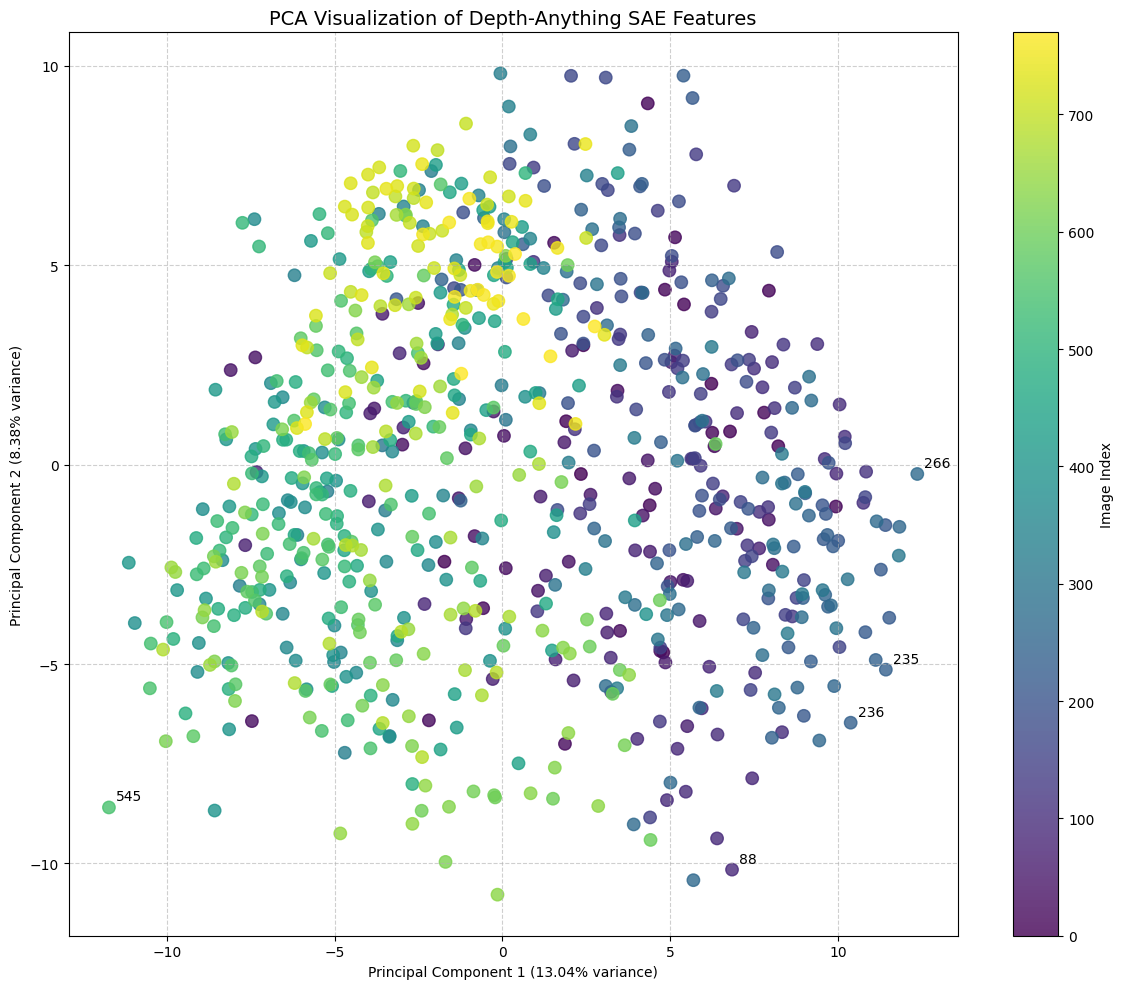

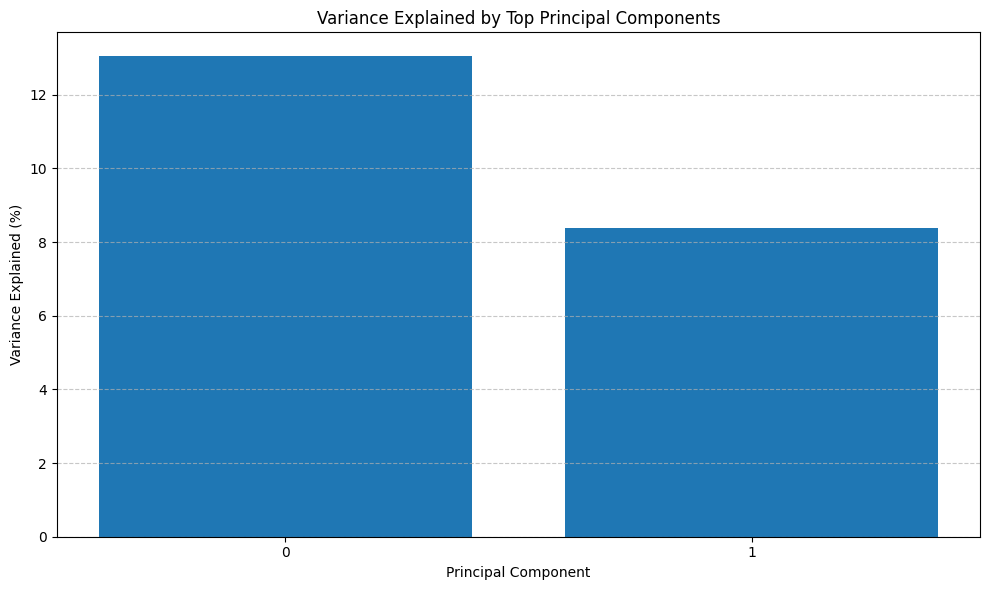

Converting depth_map from <class 'PIL.Image.Image'> to tensor
Converting mask from <class 'PIL.Image.Image'> to tensor
Converting depth_map from <class 'PIL.Image.Image'> to tensor
Converting mask from <class 'PIL.Image.Image'> to tensor
Converting depth_map from <class 'PIL.Image.Image'> to tensor
Converting mask from <class 'PIL.Image.Image'> to tensor
Converting depth_map from <class 'PIL.Image.Image'> to tensor
Converting mask from <class 'PIL.Image.Image'> to tensor
Converting depth_map from <class 'PIL.Image.Image'> to tensor
Converting mask from <class 'PIL.Image.Image'> to tensor
Converting depth_map from <class 'PIL.Image.Image'> to tensor
Converting mask from <class 'PIL.Image.Image'> to tensor
Converting depth_map from <class 'PIL.Image.Image'> to tensor
Converting mask from <class 'PIL.Image.Image'> to tensor
Converting depth_map from <class 'PIL.Image.Image'> to tensor
Converting mask from <class 'PIL.Image.Image'> to tensor
Converting depth_map from <class 'PIL.Image.Imag

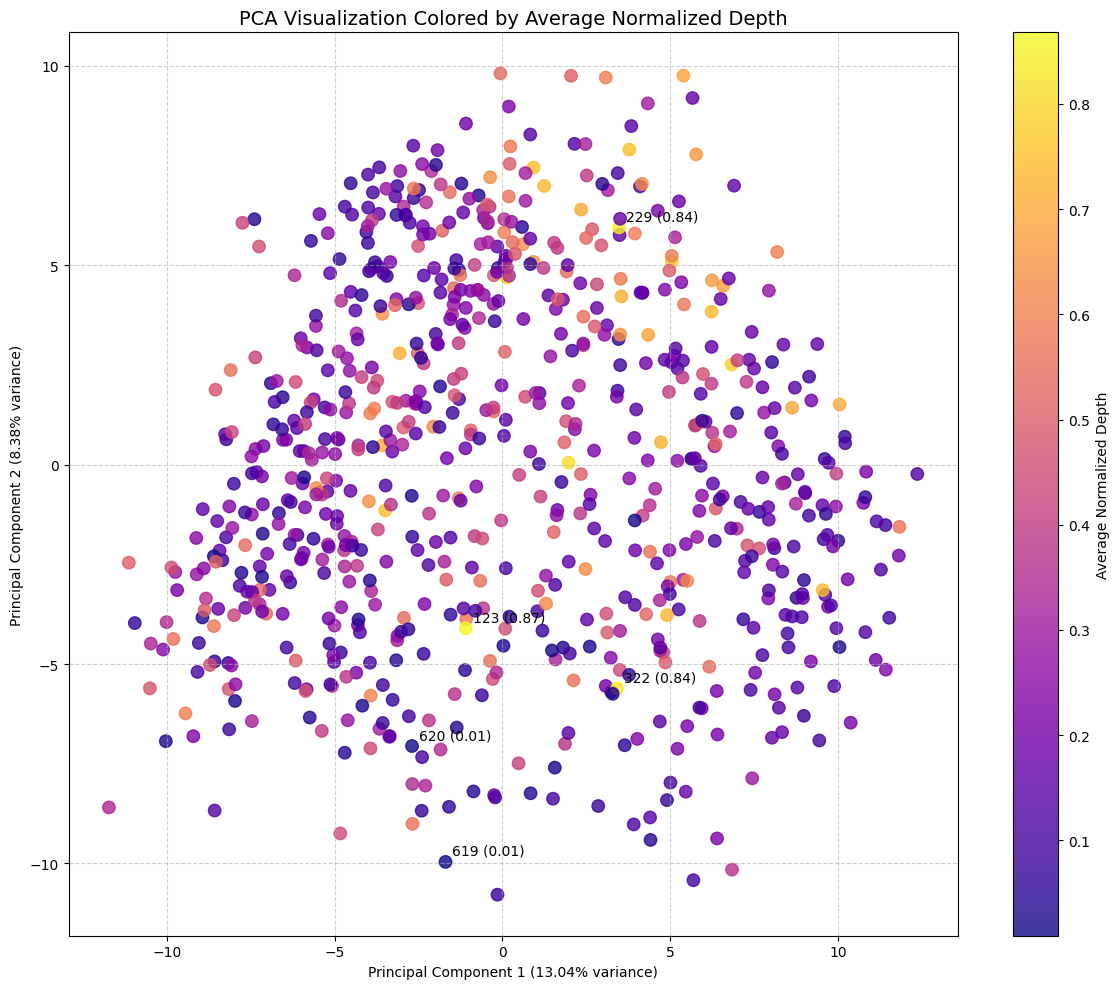

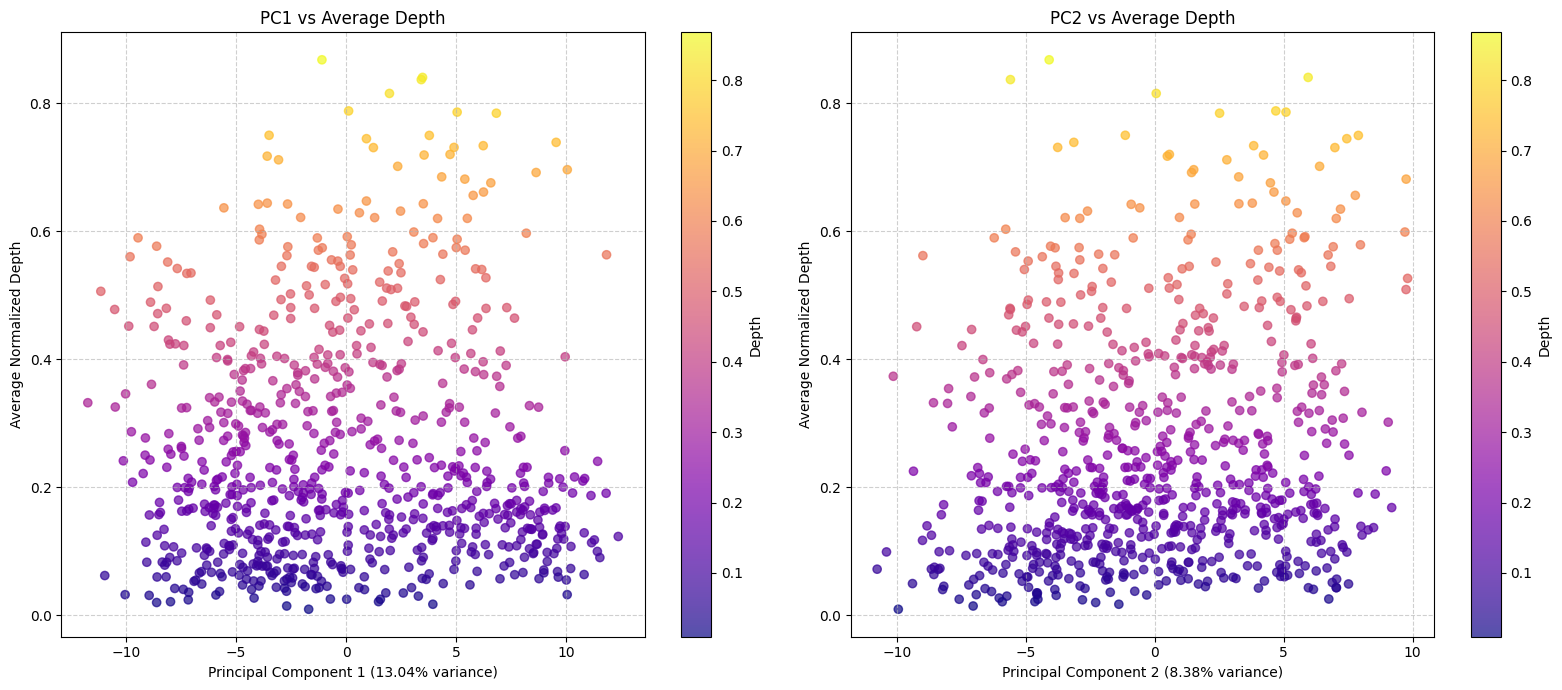

Correlation between PC1 and average depth: 0.0051
Correlation between PC2 and average depth: 0.1778


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
import torch

# Assuming sae_features is your array of shape (200, 32768)
# Apply PCA to reduce to 2 dimensions
print(f"Original feature shape: {sae_features.shape}")

# Create a PCA model with 2 components
pca = PCA(n_components=2)
features_2d = pca.fit_transform(sae_features)

print(f"Transformed feature shape: {features_2d.shape}")
print(f"Variance explained by first two components: {pca.explained_variance_ratio_}")
print(f"Cumulative variance explained: {np.sum(pca.explained_variance_ratio_):.4f}")

# Create a scatter plot of the 2D points colored by index
plt.figure(figsize=(12, 10))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=np.arange(len(features_2d)), 
                     cmap='viridis', alpha=0.8, s=80)

# Add color bar to show order of points
plt.colorbar(scatter, label='Image Index')

# Add labels and title
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA Visualization of Depth-Anything SAE Features', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Find outliers (points far from the center)
distances = np.sqrt(features_2d[:, 0]**2 + features_2d[:, 1]**2)
outliers = np.argsort(distances)[-5:]  # Get indices of 5 furthest points

# Annotate 5 most extreme points with their indices
for i in outliers:
    plt.annotate(f"{i}", (features_2d[i, 0], features_2d[i, 1]), 
                fontsize=10, xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Create a second plot showing variance explained by each component
plt.figure(figsize=(10, 6))
components = min(20, len(pca.explained_variance_ratio_))  # Show at most 20 components
plt.bar(range(components), pca.explained_variance_ratio_[:components] * 100)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Variance Explained by Top Principal Components')
plt.xticks(range(components))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Now create a plot colored by average normalized depth
# First, collect the average depth for each image
avg_depths = []
num_samples = len(diode_dataset)  # Same as used for embedding extraction

for i in range(num_samples):
    sample = diode_dataset[i]
    depth_map = sample['depth']  # This is a tensor with shape [1, H, W]
    mask = sample['mask']  # Valid depth mask
    
    # Ensure we have tensors
    if not isinstance(depth_map, torch.Tensor):
        print(f"Converting depth_map from {type(depth_map)} to tensor")
        # If it's a PIL Image, convert to numpy array first
        if hasattr(depth_map, 'convert'):
            depth_map = np.array(depth_map)
        depth_map = torch.tensor(depth_map, dtype=torch.float32)
    
    if not isinstance(mask, torch.Tensor):
        print(f"Converting mask from {type(mask)} to tensor")
        if hasattr(mask, 'convert'):
            mask = np.array(mask)
        mask = torch.tensor(mask, dtype=torch.bool)
    
    # Ensure depth_map has proper shape
    if depth_map.dim() == 2:
        depth_map = depth_map.unsqueeze(0)  # Add channel dimension
    
    # Ensure mask has proper shape
    if mask.dim() == 2:
        mask = mask.unsqueeze(0)  # Add channel dimension
    
    # Calculate average depth for valid pixels
    if mask.sum() > 0:
        # Extract depth values where mask is True
        valid_depths = depth_map[mask]
        
        # Normalize the depth values to [0, 1] range for consistent coloring
        min_depth = valid_depths.min().item()
        max_depth = valid_depths.max().item()
        
        # Calculate normalized average depth
        avg_depth = valid_depths.mean().item()
        avg_depth_norm = (avg_depth - min_depth) / (max_depth - min_depth + 1e-8)
    else:
        # If no valid depths, use 0
        avg_depth_norm = 0.0
    
    avg_depths.append(avg_depth_norm)

# Convert to numpy array
avg_depths = np.array(avg_depths)

# Create scatter plot colored by average normalized depth
plt.figure(figsize=(12, 10))

# Create a color normalization
norm = Normalize(vmin=avg_depths.min(), vmax=avg_depths.max())

# Create scatter plot
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                      c=avg_depths, cmap='plasma', 
                      alpha=0.8, s=80, norm=norm)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Average Normalized Depth')

# Add labels and title
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA Visualization Colored by Average Normalized Depth', fontsize=14)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Annotate 5 most extreme depth values
depth_extremes = np.concatenate([np.argsort(avg_depths)[-3:], np.argsort(avg_depths)[:2]])
for i in depth_extremes:
    plt.annotate(f"{i} ({avg_depths[i]:.2f})", (features_2d[i, 0], features_2d[i, 1]), 
                fontsize=10, xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Additionally, create a scatter plot showing PC1 vs Average Depth and PC2 vs Average Depth
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# PC1 vs Average Depth
scatter1 = ax1.scatter(features_2d[:, 0], avg_depths, alpha=0.7, c=avg_depths, cmap='plasma')
ax1.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
ax1.set_ylabel('Average Normalized Depth')
ax1.set_title('PC1 vs Average Depth')
ax1.grid(True, linestyle='--', alpha=0.6)
fig.colorbar(scatter1, ax=ax1, label='Depth')

# PC2 vs Average Depth
scatter2 = ax2.scatter(features_2d[:, 1], avg_depths, alpha=0.7, c=avg_depths, cmap='plasma')
ax2.set_xlabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
ax2.set_ylabel('Average Normalized Depth')
ax2.set_title('PC2 vs Average Depth')
ax2.grid(True, linestyle='--', alpha=0.6)
fig.colorbar(scatter2, ax=ax2, label='Depth')

plt.tight_layout()
plt.show()

# Calculate correlation coefficients
pc1_depth_corr = np.corrcoef(features_2d[:, 0], avg_depths)[0, 1]
pc2_depth_corr = np.corrcoef(features_2d[:, 1], avg_depths)[0, 1]

print(f"Correlation between PC1 and average depth: {pc1_depth_corr:.4f}")
print(f"Correlation between PC2 and average depth: {pc2_depth_corr:.4f}")